In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SS
import torch
from torchinfo import summary
from torch import nn
import pickle
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("D:\PyCharmProject\polyuSubject\COMP5434\data.csv")
x = data.iloc[:,:-1].values
y = data['label'].values
x, y

(array([[5.        , 2.5       , 7.94449216, ..., 0.        , 0.        ,
         0.        ],
        [2.        , 1.        , 7.09837564, ..., 0.        , 0.        ,
         0.        ],
        [4.        , 2.5       , 7.69621264, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [4.        , 2.5       , 8.11969625, ..., 0.        , 0.        ,
         0.        ],
        [6.        , 2.5       , 7.8785342 , ..., 0.        , 0.        ,
         0.        ],
        [5.        , 4.25      , 8.71111388, ..., 0.        , 0.        ,
         0.        ]]),
 array([2, 0, 0, ..., 3, 3, 3], dtype=int64))

In [3]:
scaler = SS()
x = scaler.fit_transform(x)
pickle.dump(scaler, open('scaler.pkl','wb'))

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=1, test_size=0.2)
xx = torch.tensor(X_train, dtype=torch.float, requires_grad=True)
yy = torch.tensor(Y_train, dtype=torch.long, requires_grad=False)

In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [29]:
class ANN(torch.nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        layers = []
        layers += [nn.Linear(50, 256), nn.ReLU(inplace=True)]
        for i in range(n_layers):
            layers += [nn.Linear(256, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True)]
        layers += [nn.Linear(256, 4), nn.ReLU(inplace=True)]
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        return x
loss_func = torch.nn.CrossEntropyLoss()
batch_size = 128

Adding hidden layers

0 44.53125 44.53125 44.53125 44.53125
10 74.21875 70.3125 57.03125 44.53125
20 77.34375 72.65625 67.96875 55.46875
30 78.125 72.65625 71.875 57.03125
40 78.125 74.21875 72.65625 58.59375
50 77.34375 75.78125 74.21875 63.28125
60 77.34375 76.5625 75.0 65.625
70 78.125 78.125 76.5625 74.21875
80 78.125 78.125 77.34375 75.0
90 78.125 77.34375 75.78125 77.34375
100 79.6875 77.34375 77.34375 77.34375
110 78.90625 78.90625 78.90625 78.125
120 80.46875 78.90625 77.34375 77.34375
130 78.90625 79.6875 77.34375 76.5625
140 79.6875 77.34375 76.5625 77.34375
150 78.90625 76.5625 76.5625 76.5625
160 79.6875 77.34375 76.5625 78.90625
170 78.125 78.125 78.125 78.125
180 78.90625 78.125 78.125 78.90625
190 79.6875 78.125 77.34375 78.125


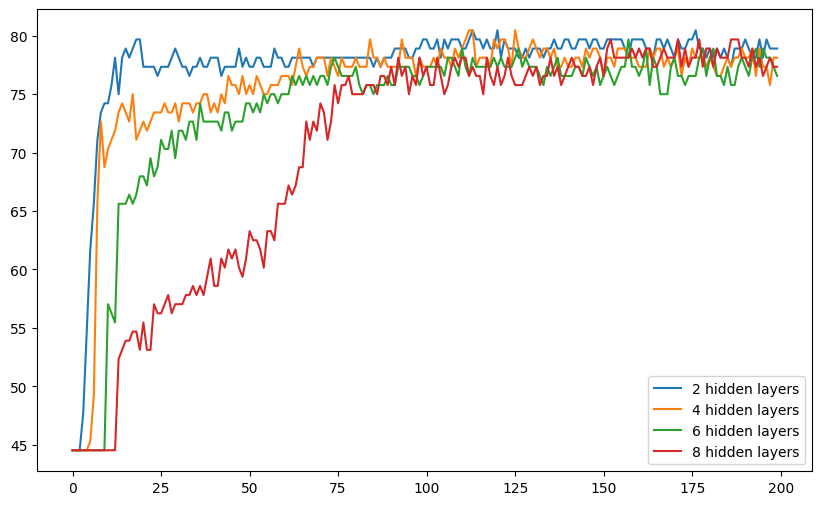

In [150]:
def seed_everything(seed=1234, is_cuda=False):
    """Some configurations for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if is_cuda:
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # torch.cuda.manual_seed(args.seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1234, True)

net2 = ANN(2)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.0001)
net3 = ANN(4)
optimizer3 = torch.optim.Adam(net3.parameters(), lr=0.0001)
net4 = ANN(6)
optimizer4 = torch.optim.Adam(net4.parameters(), lr=0.0001)
net5 = ANN(8)
optimizer5 = torch.optim.Adam(net5.parameters(), lr=0.0001)

def train(net, X_train, Y_train, criterion, optimizer):
    net.train()
    batch_loss = []
    train_all_acc = []
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size if start + batch_size < len(X_train) else len(X_train)
        xx = torch.tensor(X_train[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(Y_train[start:end], dtype=torch.long, requires_grad=False)
        out = net(xx)
        loss = criterion(out, yy)
        acc1, acc5 = accuracy(out, yy, topk=(1, 1))
        train_all_acc.append(acc1.cpu().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    train_acc = max(train_all_acc)
    train_loss = np.mean(batch_loss)
    return train_acc, train_loss

def test(net, X_test, Y_test, criterion):
    net.eval()
    batch_loss = []
    test_all_acc = []
    with torch.no_grad():
        for start in range(0, len(X_test), batch_size):
            end = start + batch_size if start + batch_size < len(X_test) else len(X_test)
            single_test_xx = torch.tensor(X_test[start:end], dtype=torch.float, requires_grad=False)
            single_test_yy = torch.tensor(Y_test[start:end], dtype=torch.long, requires_grad=False)
            test_pred = net(single_test_xx)
            test_loss = criterion(test_pred, single_test_yy)
            test_acc1, test_acc5 = accuracy(test_pred, single_test_yy, topk=(1, 1))
            test_all_acc.append(test_acc1.cpu().item())
            batch_loss.append(test_loss.data.numpy())
    test_acc = max(test_all_acc)
    test_loss = np.mean(batch_loss)
    return test_acc, test_loss


plot_test_acc_2 = []
plot_train_acc2 = []
plot_test_acc_3 = []
plot_test_acc_4 = []
plot_test_acc_5 = []
for epoch in range(200):    
    train_acc_2, train_loss_2 = train(net2, X_train, Y_train, loss_func, optimizer2)
    test_acc_2, test_loss_2 = test(net2, X_test, Y_test, loss_func)
    plot_test_acc_2.append(test_acc_2)
    plot_train_acc2.append(train_acc_2)
    
    train_acc_3, train_loss_3 = train(net3, X_train, Y_train, loss_func, optimizer3)
    test_acc_3, test_loss_3 = test(net3, X_test, Y_test, loss_func)
    plot_test_acc_3.append(test_acc_3)
    
    train_acc_4, train_loss_4 = train(net4, X_train, Y_train, loss_func, optimizer4)
    test_acc_4, test_loss_4 = test(net4, X_test, Y_test, loss_func)
    plot_test_acc_4.append(test_acc_4)

    train_acc_5, train_loss_5 = train(net5, X_train, Y_train, loss_func, optimizer5)
    test_acc_5, test_loss_5 = test(net5, X_test, Y_test, loss_func)
    plot_test_acc_5.append(test_acc_5)

    if epoch % 10 == 0:
        print(epoch, test_acc_2, test_acc_3, test_acc_4, test_acc_5)

plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_test_acc_2)
plt.plot(range(0, 200), plot_test_acc_3)
plt.plot(range(0, 200), plot_test_acc_4)
plt.plot(range(0, 200), plot_test_acc_5)
plt.legend(['2 hidden layers', '4 hidden layers', '6 hidden layers', '8 hidden layers'])
plt.show()

Adding BatchNorm1d

0 64.84375 64.84375
20 75.0 76.5625
40 71.09375 78.125
60 71.875 78.125
80 71.09375 78.125
100 69.53125 78.125
120 71.875 78.125
140 71.875 78.125
160 71.875 78.125
180 73.4375 78.125


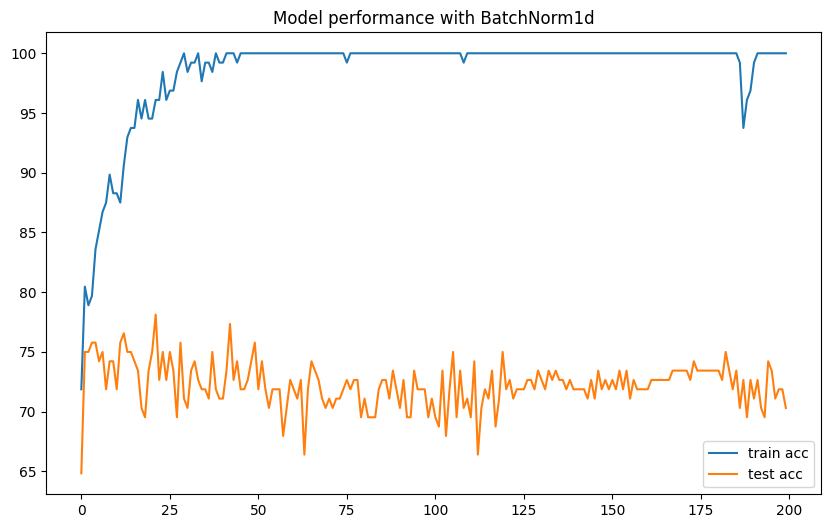

In [31]:
def seed_everything(seed=1234, is_cuda=False):
    """Some configurations for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if is_cuda:
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # torch.cuda.manual_seed(args.seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1234, True)

init_lr = 0.001

def train(net, X_train, Y_train, criterion, optimizer):
    net.train()
    batch_loss = []
    train_all_acc = []
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size if start + batch_size < len(X_train) else len(X_train)
        xx = torch.tensor(X_train[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(Y_train[start:end], dtype=torch.long, requires_grad=False)
        out = net(xx)
        loss = criterion(out, yy)
        acc1, acc5 = accuracy(out, yy, topk=(1, 1))
        train_all_acc.append(acc1.cpu().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    train_acc = max(train_all_acc)
    train_loss = np.mean(batch_loss)
    return train_acc, train_loss

def test(net, X_test, Y_test, criterion):
    net.eval()
    batch_loss = []
    test_all_acc = []
    with torch.no_grad():
        for start in range(0, len(X_test), batch_size):
            end = start + batch_size if start + batch_size < len(X_test) else len(X_test)
            single_test_xx = torch.tensor(X_test[start:end], dtype=torch.float, requires_grad=False)
            single_test_yy = torch.tensor(Y_test[start:end], dtype=torch.long, requires_grad=False)
            test_pred = net(single_test_xx)
            test_loss = criterion(test_pred, single_test_yy)
            test_acc1, test_acc5 = accuracy(test_pred, single_test_yy, topk=(1, 1))
            test_all_acc.append(test_acc1.cpu().item())
            batch_loss.append(test_loss.data.numpy())
    test_acc = max(test_all_acc)
    test_loss = np.mean(batch_loss)
    return test_acc, test_loss

net_lr_decay = ANN(4)
optimizer = torch.optim.Adam(net_lr_decay.parameters(), lr=init_lr)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

plot_test_acc = []
plot_train_acc = []
curr_lr = init_lr
max_acc = 0
for epoch in range(200):    
    train_acc, train_loss = train(net_lr_decay, X_train, Y_train, loss_func, optimizer)
    test_acc, test_loss = test(net_lr_decay, X_test, Y_test, loss_func)
    plot_test_acc.append(test_acc)
    plot_train_acc.append(train_acc)
    if test_acc >= max_acc:
        max_acc = test_acc
    
    if epoch % 20 == 0:
        print(epoch, test_acc, max_acc)
#         curr_lr /= 1.5
#         update_lr(optimizer, curr_lr)
    
plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), plot_train_acc)
plt.plot(range(0, 200), plot_test_acc)
plt.legend(['train acc', 'test acc'])
plt.title('Model performance with BatchNorm1d')
plt.show()

Adding Spiking Neurons

In [9]:
from spikingjelly.activation_based import neuron, surrogate, layer, functional

# seed_everything(1234, True)
class SNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            layer.Linear(50, 256),
            
            layer.Linear(256, 256),
#             nn.BatchNorm1d(256),
            neuron.IFNode(detach_reset=True, surrogate_function=surrogate.S2NN()),
                
            layer.Linear(256, 256),
            neuron.IFNode(detach_reset=True, surrogate_function=surrogate.S2NN()),
                
#                 layer.Linear(256, 256),
#                 nn.Dropout(0.5),
#                 neuron.IFNode(detach_reset=True, surrogate_function=surrogate.ATan()),
                
            layer.Linear(256, 4),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        return self.fc(x)
    
loss_func = torch.nn.CrossEntropyLoss()
batch_size = 128

In [11]:
def seed_everything(seed=1234, is_cuda=False):
    """Some configurations for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if is_cuda:
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # torch.cuda.manual_seed(args.seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(1234, True)

def train_snn(net, X_train, Y_train, criterion, optimizer):
    net.train()
    batch_loss = []
    train_all_acc = []
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size if start + batch_size < len(X_train) else len(X_train)
        xx = torch.tensor(X_train[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(Y_train[start:end], dtype=torch.long, requires_grad=False)
        out = net(xx)
        loss = criterion(out, yy)
        acc1, acc5 = accuracy(out, yy, topk=(1, 1))
        train_all_acc.append(acc1.cpu().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        functional.reset_net(net)
    train_acc = max(train_all_acc)
    train_loss = np.mean(batch_loss)
    return train_acc, train_loss

def test_snn(net, X_test, Y_test, criterion):
    net.eval()
    batch_loss = []
    test_all_acc = []
    with torch.no_grad():
        for start in range(0, len(X_test), batch_size):
            end = start + batch_size if start + batch_size < len(X_test) else len(X_test)
            single_test_xx = torch.tensor(X_test[start:end], dtype=torch.float, requires_grad=False)
            single_test_yy = torch.tensor(Y_test[start:end], dtype=torch.long, requires_grad=False)
            test_pred = net(single_test_xx)
            test_loss = criterion(test_pred, single_test_yy)
            test_acc1, test_acc5 = accuracy(test_pred, single_test_yy, topk=(1, 1))
            test_all_acc.append(test_acc1.cpu().item())
            batch_loss.append(test_loss.data.numpy())
            functional.reset_net(net)
    test_acc = max(test_all_acc)
    test_loss = np.mean(batch_loss)
    return test_acc, test_loss

init_lr = 0.00005

net_snn = SNN()
optimizer = torch.optim.Adam(net_snn.parameters(), lr=init_lr)
functional.set_step_mode(net_snn, step_mode='s')
# functional.set_backend(net_snn, backend='cupy')


SNN_test_acc = []
SNN_train_acc = []
max_acc = 0
for epoch in range(200):    
    train_acc, train_loss = train_snn(net_snn, X_train, Y_train, loss_func, optimizer)
    test_acc, test_loss = test_snn(net_snn, X_test, Y_test, loss_func)
    SNN_test_acc.append(test_acc)
    SNN_train_acc.append(train_acc)
    if test_acc >= max_acc:
        max_acc = test_acc
        torch.save(net_snn.state_dict(), './best_model_2_bonus.pth')
    if epoch % 10 == 0:
        print(epoch, train_acc, test_acc, max_acc)

0 29.6875 28.125 28.125
10 31.25 28.125 28.125
20 65.625 64.0625 64.0625
30 73.4375 71.875 71.875
40 75.78125 75.78125 75.78125
50 80.46875 77.34375 77.34375
60 81.25 78.125 78.90625
70 81.25 79.6875 79.6875
80 85.9375 78.90625 80.46875
90 85.9375 79.6875 81.25
100 87.5 80.46875 81.25
110 86.71875 82.03125 82.03125
120 87.5 80.46875 82.8125
130 85.9375 81.25 82.8125
140 87.5 78.90625 82.8125
150 87.5 79.6875 82.8125
160 85.9375 81.25 82.8125
170 85.9375 81.25 82.8125
180 86.71875 79.6875 82.8125
190 88.28125 82.8125 83.59375


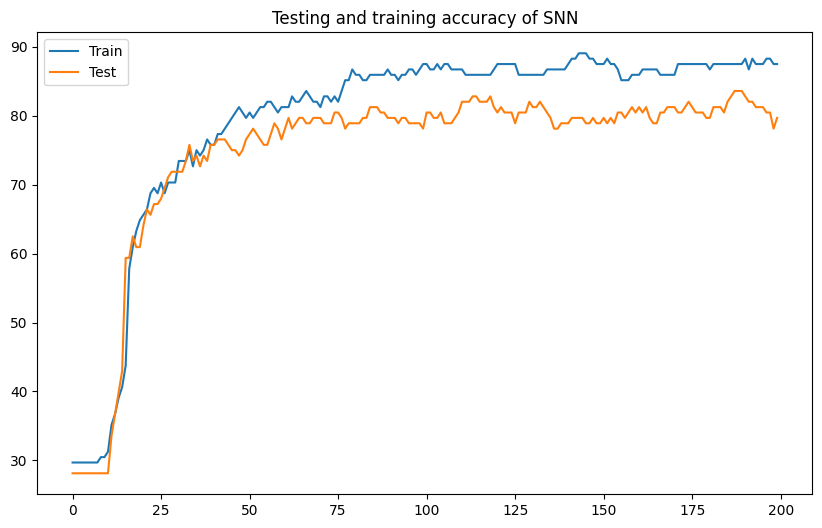

In [12]:
plt.figure(figsize=[10, 6])
plt.plot(range(0, 200), SNN_train_acc)
plt.plot(range(0, 200), SNN_test_acc)
plt.title('Testing and training accuracy of SNN')
plt.legend(['Train', 'Test'])
plt.show()

In [14]:
# inference
test_data = pd.read_csv(r'D:\PyCharmProject\polyuSubject\COMP5434\test_data.csv')
x_test = test_data.values
scaler = pickle.load(open('scaler.pkl', 'rb'))
x_test = scaler.transform(x_test)
inference_net = SNN()
inference_net.load_state_dict(torch.load('best_model_2_bonus.pth'))
res = []
x_test = torch.tensor(x_test, dtype=torch.float, requires_grad=False)
for i in range(len(x_test)):
    out = inference_net(x_test[i])
    out = out.detach().numpy().tolist()
    label = out.index(max(out))
    res.append(label)
res

[3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 1,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 3,
 3,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 3,


In [15]:
pd.DataFrame(np.array(res).reshape((-1,1))).to_csv("test_res_bonus1.csv")